In [35]:
import typing as t

import gymnasium as gym
import enerflow as ef

import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.iolib.smpickle import load_pickle

import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### **Load data**

In [36]:
df_heftcom = pd.read_csv("data/data_heftcom2024.csv", index_col=[0, 1], parse_dates=["ref_datetime", "valid_datetime", "market_day"])
df_coords_hornsea1 = pd.read_csv("data/dwd_coords_hornsea1.csv")
df_coords_pes10 = pd.read_csv("data/dwd_coords_pes10.csv")
area_pes10 = ef.GeoMultiPolygon.from_geojson("data/pes10.geojson")

### **Create and plot energy system** 

In [37]:
windfarm = ef.WindFarm(name="Hornsea 1", longitude=1.79, latitude=53.90, capacity=1218)
solar_pes10 = ef.SolarPowerArea(geopolygon=area_pes10) 
portfolio = ef.Portfolio(assets=[solar_pes10, windfarm])

In [38]:
m = folium.Map(location=[53.5, 0], zoom_start=6.4)

feature_group1 = folium.FeatureGroup(name='Wind Farm Hornsea 1')
folium.CircleMarker(location=[windfarm.latitude, windfarm.longitude], radius=10, color='blue').add_to(feature_group1)
feature_group1.add_to(m)

feature_group2 = folium.FeatureGroup(name='Solar PES10')
folium.GeoJson(solar_pes10.geopolygon.multipolygon, name='geopolygon').add_to(feature_group2)
feature_group2.add_to(m)

feature_group3 = folium.FeatureGroup(name='DWD grid points')
for lat in df_coords_hornsea1.latitude.values:
    for lon in df_coords_hornsea1.longitude.values:
        folium.CircleMarker(location=[lat, lon], radius=0.1, color='red').add_to(feature_group3)
for index, row in df_coords_pes10.iterrows():
    folium.CircleMarker(location=[row.latitude, row.longitude], radius=0.1, color='red').add_to(feature_group3)
feature_group3.add_to(m)

folium.LayerControl().add_to(m)

m

### **Create Environment**

In [85]:
dataset = ef.Dataset(name="heftcom2024",
                     description="All data provided by the organisers of HEFTCom2024. Participants are free to use additional external data.",
                     energy_system=portfolio,
                     data={"data_heftcom2024": df_heftcom, "dwd_coords_hornsea1": df_coords_hornsea1, "dwd_coords_pes10": df_coords_pes10})

In [98]:
time_space = gym.spaces.Text(max_length=10, min_length=10)

state_space = gym.spaces.Dict(
    {
        "solar_power": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
        "solar_installed": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
        "solar_available": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
        "solar_forecast": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
        "wind_power": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
        "wind_forecast": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
    }
)

exogeneous_space = gym.spaces.Dict(
    {
        "dayahead_price": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(48,1)),
        "imbalance_price": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(48,1)),
    }
)

action_space = gym.spaces.Dict(
    {
        "power_quantile_forecast": gym.spaces.Box(low=0, high=np.inf, shape=(48,9)),
        "power_bid": gym.spaces.Box(low=0, high=np.inf, shape=(48,1)),
    }
)

In [204]:
class HEFTCom2024Environment(gym.Env):

    def __init__(self, 
                 dataset: ef.Dataset,
                 train_end: t.Optional[pd.Timestamp] = None,
                 time_lags: t.Optional[t.Dict[str, t.Union[int, None]]] = None,):
        
        self.time_space = time_space
        self.state_space = state_space
        self.exogeneous_space = exogeneous_space
        self.action_space = action_space
        
        self.data = dataset.data["data_heftcom2024"]
        self.portfolio = dataset.energy_system
        self.train_end = train_end if train_end is not None else self.data["market_day"].max()
        self.market_days = self.data['market_day'].unique()
        self.n_market_days = len(self.market_days)
        self.idx_first_eval_day = list(self.market_days > self.train_end).index(True)
        self.idx_counter = 0

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        initial_dataframe = self.data[self.data["market_day"] <= self.train_end]
        ref_times, states, exogenous = self._create_states(self.market_days[:self.idx_first_eval_day])

        if return_dataframe:
            return ref_times, states, exogenous, initial_dataframe
        else:
            return ref_times, states, exogenous

    def _create_state(self, idx_market_day):
        market_day_previous = self.market_days[idx_market_day-1]
        market_day = self.market_days[idx_market_day]
        
        market_day_start_previous = self.data[self.data["market_day"] == market_day_previous].index.get_level_values(1)[0]
        market_day_start = self.data[self.data["market_day"] == market_day].index.get_level_values(1)[0]

        ref_time = market_day.strftime('%Y-%m-%d')

        next_state = {
            "solar_power": self.data.loc[market_day_start_previous:market_day_start, ["Solar_MWh_credit"]].values,
            "solar_installed": self.data.loc[market_day_start_previous:market_day_start, ["Solar_installedcapacity_mwp"]].values,
            "solar_available": self.data.loc[market_day_start_previous:market_day_start, ["Solar_capacity_mwp"]].values,
            "solar_forecast": self.data[self.data["market_day"] == market_day][["SolarDownwardRadiation"]].values,
            "wind_power": self.data.loc[market_day_start_previous:market_day_start, ["Wind_MWh_credit"]].values,
            "wind_forecast": self.data[self.data["market_day"] == market_day][["WindSpeed"]].values,
            "dayahead_price": self.data.loc[market_day_start_previous:market_day_start, ["DA_Price"]].values,
            "imbalance_price": self.data.loc[market_day_start_previous:market_day_start, ["SS_Price"]].values
        }

        exogenous = {
            "dayahead_price": self.data[self.data["market_day"] == market_day][["DA_Price"]].values,
            "imbalance_price": self.data[self.data["market_day"] == market_day][["SS_Price"]].values,
        }

        return ref_time, next_state, exogenous
     
    def _create_states(self, market_days):
        ref_times = []
        states = []
        exogenous = []
        for idx in range(1, len(market_days)):
            ref_time, state, exog = self._create_state(idx)
            ref_times.append(ref_time)
            states.append(state)
            exogenous.append(exog)
            
        return ref_times, states, exogenous

    def step(self, action=None):
        idx_market_day = self.idx_first_eval_day+self.idx_counter
        ref_time, next_state, exogenous = self._create_state(idx_market_day)
        done = True if idx_market_day+1 == self.n_market_days else False
        self.idx_counter += 1
        
        return ref_time, next_state, exogenous, done

In [205]:
env = HEFTCom2024Environment(dataset=dataset, 
                             train_end="2023-10-15")
ref_times, states, exogenous, initial_df = env.reset(return_dataframe=True)

### **Create Objective**

In [103]:
from enerflow.problems.objectives import PinballLoss
from enerflow.problems.objectives import BaseScore

class MarketRevenue(BaseScore):

    def calculate(self, bid, production, day_ahead_price, single_system_price):
        revenue = bid * day_ahead_price + (production - bid) * (single_system_price - 0.07 * (production - bid))

        return revenue

### **Create Predictor**

In [104]:
class Predictor(ef.Predictor):
        def __init__(self):
            self.model_name = "quantreg"
            self.quantiles = range(10,100,10)
            self.models = dict()

        def save_model(self, path: str):
            for quantile in self.quantiles:
                self.models[f"q{quantile}"].save(f"{path}/{self.model_name}_q{quantile}.pickle")
        
        def load_model(self, path: str):
            for quantile in self.quantiles:
                self.models[f"q{quantile}"] = load_pickle(f"{path}/{self.model_name}_q{quantile}.pickle")

        def train(self, X, y):
            train_data = {**X, **y}
            train_data = pd.DataFrame({k: v.squeeze() for k, v in train_data.items()})
            mod = smf.quantreg('total_generation_MWh ~ bs(solar_forecast,df=5) + bs(wind_forecast,df=8)',
                               data=train_data)
    
            for quantile in range(10,100,10):
                print(quantile)
                self.models[f"q{quantile}"] = mod.fit(q=quantile/100, max_iter=2500)

        def predict(self, X: dict) -> dict:
            X = pd.DataFrame({k: v.squeeze() for k, v in X.items()})
            
            prediction = pd.DataFrame()
            for quantile in range(10,100,10):
                prediction[f"q{quantile}"] = self.models[f"q{quantile}"].predict(X)
                prediction.loc[prediction[f"q{quantile}"] < 0, f"q{quantile}"] = 0
                
            return prediction.values

In [105]:
train_data = initial_df[["WindSpeed", "SolarDownwardRadiation", "total_generation_MWh"]].dropna()
X = {
    "solar_forecast": train_data["SolarDownwardRadiation"].values,
    "wind_forecast": train_data["WindSpeed"].values
}
y = {
    "total_generation_MWh": train_data["total_generation_MWh"].values
}

In [23]:
predictor = Predictor()
predictor.train(X, y)
predictor.save_model("models")

10
20
30
40
50
60
70
80
90


/Users/sebaheg/Documents/Github/enerflow/enerflow/examples/heftcom2024/.venv_heftcom2024/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [109]:
y_true = y["total_generation_MWh"].reshape(-1,1)
y_preds = predictor.predict(X)

pinball = PinballLoss(quantiles=np.arange(0.1,1,0.1))
scores = pinball.score(y_true, y_preds)
scores

32.092224429059414

### **Create Agent**

In [110]:
from enerflow.problems.objectives import BaseScore

class MarketRevenue(BaseScore):

    def calculate(self, bid, production, day_ahead_price, single_system_price):
        revenue = bid * day_ahead_price + (production - bid) * (single_system_price - 0.07 * (production - bid))

        return revenue

In [111]:
class Optimizer(ef.Optimizer):
    
    def optimize(self, prediction): 
        bid = prediction[:,4].reshape(-1,1)
        
        return bid
    
optimizer = Optimizer()

In [142]:
class Agent(ef.Agent):
    
    def __init__(self, predictor, optimizer):
        self.predictor = predictor
        self.optimizer = optimizer

    def load_predictor(self, path: str):
        self.predictor.load_model(path)

    def train(self, X, y):
        self.predictor.train(X, y)

    def act(self, state):
        prediction = self.predictor.predict(state)
        bid = self.optimizer.optimize(prediction)
        action = {"power_quantile_forecast": prediction, "power_bid": bid}

        return action

In [143]:
initial_states = {
    "solar_forecast": initial_df["SolarDownwardRadiation"].values,
    "wind_forecast": initial_df["WindSpeed"].values
}
agent = Agent(predictor=predictor, optimizer=optimizer)
action = agent.act(initial_states)

In [144]:
scorer = MarketRevenue()
revenue = scorer.calculate(bid=action["power_bid"], 
                           production=initial_df[["total_generation_MWh"]].values, 
                           day_ahead_price=initial_df[["DA_Price"]].values, 
                           single_system_price=initial_df[["SS_Price"]].values)
np.nansum(revenue)

2534482077.9752154

In [145]:
for i in range(9):
    initial_df.loc[:, f"Predictions_q{10*(i+1)}"] = action["power_quantile_forecast"][:,[i]]
initial_df.loc[:, "Bids"] = action["power_bid"]
initial_df.loc[:, "Revenue"] = revenue

<Axes: title={'center': 'Revenue'}, xlabel='valid_datetime'>

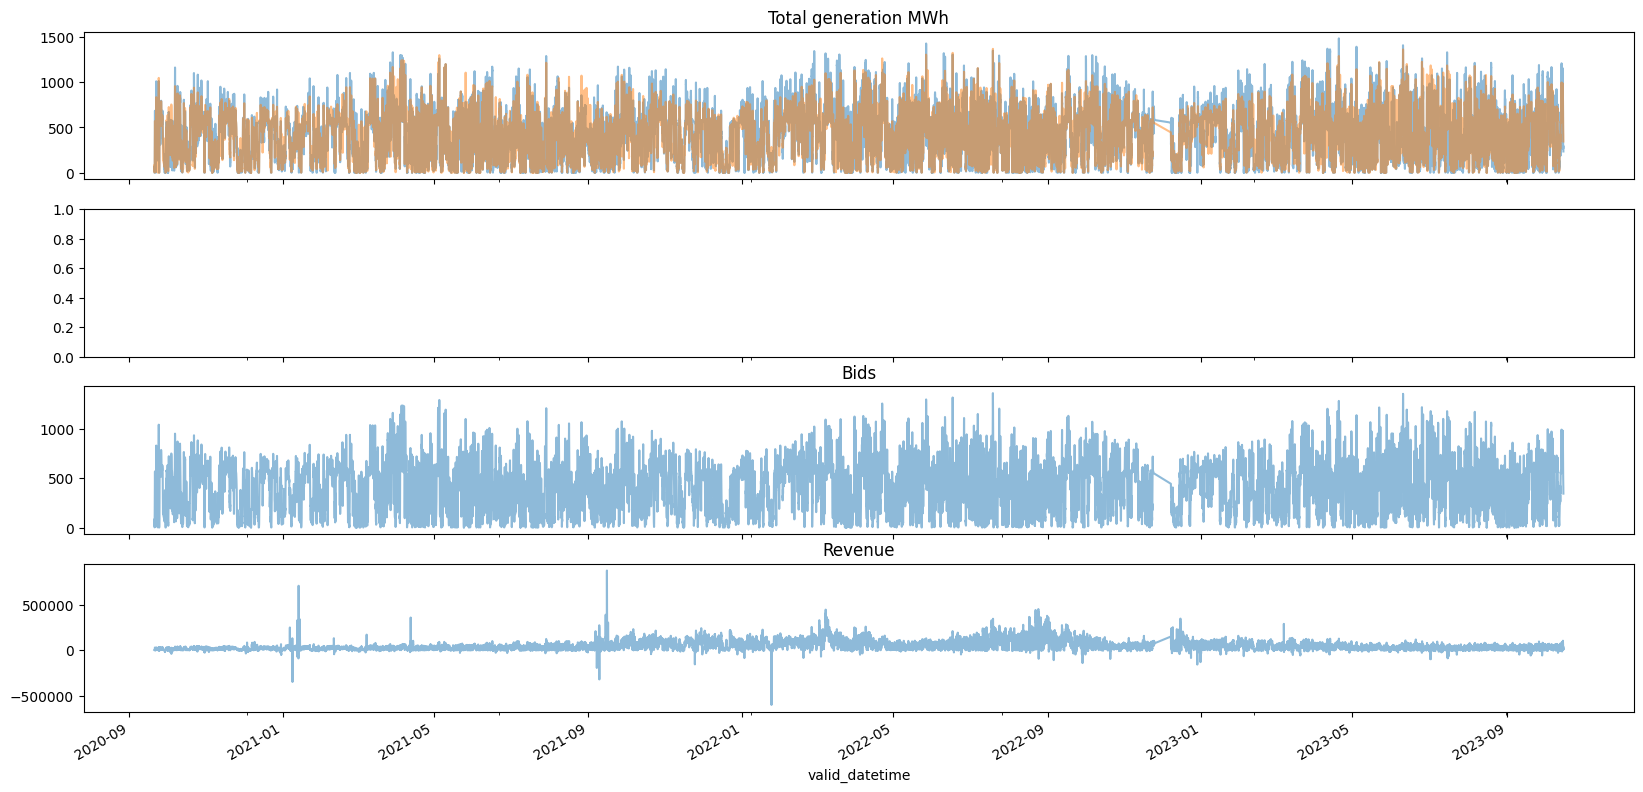

In [164]:
fig, axes = plt.subplots(4, sharex=True, figsize=(20,10))
#initial_df.index = initial_df.index.droplevel(0)
initial_df["total_generation_MWh"].plot(ax=axes[0], alpha=0.5, title="Total Power Generation [MWh]")
initial_df["Predictions_q50"].plot(ax=axes[0], alpha=0.5, title="Total generation MWh")
#for i in range(9):
#    initial_df[f"Predictions_q{10*(i+1)}"].plot(ax=axes[1], alpha=0.5, title="Qunntile Predictions")

initial_df["Bids"].plot(ax=axes[2], alpha=0.5, title="Bids")
initial_df["Revenue"].plot(ax=axes[3], alpha=0.5, title="Revenue")

## Run in backtest on validation set

In [206]:
next_state = states[-1] # First state (market day)

dfs = []
while done is not True:
   action = agent.act(next_state)
   ref_time, next_state, exogeneous, done = env.step(action)
   revenue = scorer.calculate(bid=action["power_bid"], 
                              production=next_state["solar_power"] + next_state["wind_power"],
                              day_ahead_price=exogeneous["dayahead_price"], 
                              single_system_price=exogeneous["imbalance_price"])
   

   index = pd.date_range(start=pd.to_datetime(ref_time), periods=48, freq='30min')
   df = pd.DataFrame(index=index)
   df["Predictions_q50"] = action["power_quantile_forecast"][:,[4]]
   df["Bid"] = action["power_bid"]
   
   dfs.append(df)

<Axes: >

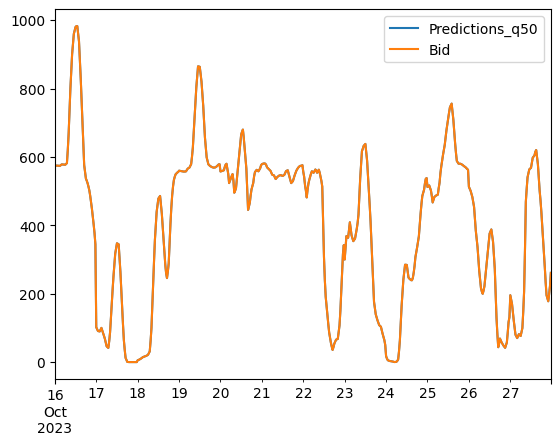

In [209]:
pd.concat(dfs).plot()